In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torch.optim as optims
from torch import nn
import torch.utils.data as Data
import os
import math
import time
from sklearn.linear_model import Lasso,LassoCV, LassoLarsIC
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.special import jv,yv
torch.set_printoptions(precision=8)
torch.manual_seed(1)
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
torch.set_default_dtype(torch.float64)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# plt.rcParams['font.sans-serif'] = 'Microsoft YaHei' #'Arial'
plt.rcParams['axes.unicode_minus'] = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
device = 'cpu'
pi = math.pi
m= 5
k = 4.5
L1 = pi
L2 = 8*pi/5
p=2
sigma = 20
dx = 0.01
j_c = torch.tensor([1j])

cuda:0


X1.shape= torch.Size([93, 2]) X2.shape= torch.Size([31, 2]) X3.shape= torch.Size([67, 2]) X4.shape= torch.Size([464, 2])


C:\Users\14688\AppData\Roaming\Python\Python311\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


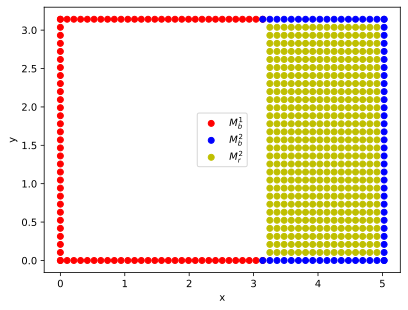

X1.shape= torch.Size([942, 2]) X2.shape= torch.Size([314, 2]) X3.shape= torch.Size([690, 2]) X4.shape= torch.Size([58032, 2])


In [3]:
# def Jvs(r):
#     return torch.special.bessel_j0(r)

# def Jvs_dr(r):
#     return -torch.special.bessel_j1(r)

#0阶第一类贝塞尔函数
def Jvs(r,ksi=0):
    return jv(ksi,r.data)

#0阶第一类贝塞尔函数的导数
def Jvs_dr(r,ksi=0):
    return 0.5*(Jvs(r,ksi-1)-Jvs(r,ksi+1))

#0阶第一类贝塞尔函数的二阶导数
def Jvs_drr(r,ksi=0):
    return 0.25*(Jvs(r,ksi-2)+Jvs(r,ksi+2)-2*Jvs(r,ksi))

def xyToPolar(x,y):
    return torch.sqrt(x**2+y**2)

def xycToPolar(X,c):
    x = X[:,0].reshape(-1,1)
    y = X[:,1].reshape(-1,1)
    return torch.sqrt((x.unsqueeze(1)-c[:,0].reshape(-1,1))**2+(y.unsqueeze(1)-c[:,1].reshape(-1,1))**2).squeeze(-1)

##SFSNN的网络输出
def get_u(X,c,h):
    r = xycToPolar(X,c)
    Phi = Jvs(k*r)
    u = torch.matmul(Phi,h).reshape(-1,1)
    return u
    
##SFSNN的网络输出对x的导数
def get_u_dx(X,c,h):
    x = X[:,0].reshape(-1,1)
    r = xycToPolar(X,c)
    r[r == 0] += 1e-15
    Phi = k*Jvs_dr(k*r)*(x.unsqueeze(1)-c[:,0].reshape(-1,1)).squeeze(-1)/r
    u_dx = torch.matmul(Phi,h).reshape(-1,1)
    return u_dx
    
##SFSNN的网络输出对y的导数
def get_u_dy(X,c,h):
    y = X[:,1].reshape(-1,1)
    r = xycToPolar(X,c)
    r[r == 0] += 1e-15
    Phi = k*Jvs_dr(k*r)*(y.unsqueeze(1)-c[:,1].reshape(-1,1)).squeeze(-1)/r
    u_dy = torch.matmul(Phi,h).reshape(-1,1)
    return u_dy

##SFSNN的网络输出对x的二阶导数
def get_u_dxx(X,c,h):
    x = X[:,0].reshape(-1,1)
    r = xycToPolar(X,c)
    r[r == 0] += 1e-15
    Phi = k*Jvs_drr(k*r,0)*((x.unsqueeze(1)-c[:,0].reshape(-1,1)).squeeze(-1)/r)**2+\
          Jvs_dr(k*r,0)*(r**2-((x.unsqueeze(1)-c[:,0].reshape(-1,1))**2).squeeze(-1))/r**3
    u_dxx = k*torch.matmul(Phi,h).reshape(-1,1)
    return u_dxx
    
##SFSNN的网络输出对y的二阶导数
def get_u_dyy(X,c,h):
    y = X[:,1].reshape(-1,1)
    r = xycToPolar(X,c)
    r[r == 0] += 1e-15
    Phi = k*Jvs_drr(k*r,0)*((y.unsqueeze(1)-c[:,1].reshape(-1,1)).squeeze(-1)/r)**2+\
          Jvs_dr(k*r,0)*(r**2-((y.unsqueeze(1)-c[:,1].reshape(-1,1))**2).squeeze(-1))/r**3
    u_dxx = k*torch.matmul(Phi,h).reshape(-1,1)
    return u_dxx

#SFSNN的网络输出对参数c的梯度
def get_u_dc(X,c,h):
    x = X[:,0].reshape(-1,1)
    y = X[:,1].reshape(-1,1)
    r = xycToPolar(X,c)
    r[r == 0] += 1e-15
    Phi_1 = k*h*Jvs_dr(k*r)*(c[:,0].reshape(-1,1)-x.unsqueeze(1)).squeeze(-1)/r
    Phi_2 = k*h*Jvs_dr(k*r)*(c[:,1].reshape(-1,1)-y.unsqueeze(1)).squeeze(-1)/r
    return torch.cat((Phi_1.unsqueeze(-1),Phi_2.unsqueeze(-1)),-1)
    
#SFSNN的网络输出对参数w的梯度
def get_u_dh(X,c):
    r = xycToPolar(X,c)
    Phi = Jvs(k*r)   #m*n
    return Phi

#定义解析解
def u_exact(x):
    if m>k:
        u=(torch.exp(-math.sqrt(m**2-k**2)*x[:,0])*torch.sin(m*x[:,1])).reshape(-1,1)
    else:
        u=(torch.exp(-1j*torch.sqrt(k**2-m**2)*x[:,0])*torch.sin(m*x[:,1])).reshape(-1,1)
    if x.is_cuda:
        u = u.to(device)
    return u

#定义解析解对x的导数
def u_dx_exact(x):
    if m>k:
        u_dx=(-math.sqrt(m**2-k**2)*torch.exp(-math.sqrt(m**2-k**2)*x[:,0])*torch.sin(m*x[:,1])).reshape(-1,1)
    else:
        u_dx=(-1j*torch.sqrt(k**2-m**2)*torch.exp(-1j*torch.sqrt(k**2-m**2)*x[:,0])*torch.sin(m*x[:,1])).reshape(-1,1)
    if x.is_cuda:
        u_dx = u_dx.to(device)
    return u_dx

#定义解析解对y的导数  
def u_dy_exact(x):
    if m>k:
        u_dy=(m*torch.exp(-math.sqrt(m**2-k**2)*x[:,0])*torch.cos(m*x[:,1])).reshape(-1,1)
    else:
        u_dy=(m*torch.exp(-1j*torch.sqrt(k**2-m**2)*x[:,0])*torch.cos(m*x[:,1])).reshape(-1,1)
    if x.is_cuda:
        u_dy = u_dy.to(device)
    return u_dy

#采样训练点集
def SampleBoundPoints(dx=dx):
    x = torch.linspace(0,L1,int(L1/(1.0*dx)),dtype=torch.float64).reshape(-1,1)
    y = torch.zeros_like(x,dtype=torch.float64)
    xx = torch.linspace(0,pi,int(L1/(1.0*dx)),dtype=torch.float64).reshape(-1,1)
    X_1 = torch.cat((x, y), dim=1)  # (x,0)
    X_2 = torch.cat((x, y+pi), dim=1)  # (x,pi)
    X_3 = torch.cat((y, xx), dim=1)  # (0,y)
    X1 = torch.cat((X_1,X_2,X_3),0)  
    
    x = torch.linspace(0,L1,int(L1/dx),dtype=torch.float64).reshape(-1,1)
    y = torch.zeros_like(x,dtype=torch.float64)
    xx = torch.linspace(0,pi,int(pi/dx),dtype=torch.float64).reshape(-1,1)
    
    X2 = torch.cat((y + L1, xx), dim=1)  # (L1,y)
    
    x = torch.linspace(L1,L2,int((L2-L1)/dx),dtype=torch.float64).reshape(-1,1)
    y = torch.zeros_like(x,dtype=torch.float64)
    
    X_4 = torch.cat((x, y), dim=1)  # (L1-L2,0)
    X_5 = torch.cat((x, y+pi), dim=1)  # (L1-L2,pi)
    X_6 = torch.cat((L2*torch.ones_like(xx), xx), dim=1)  # (L2,y)
    X3 =  torch.cat((X_4,X_5,X_6),0)

    mx,my = torch.meshgrid(x.flatten()[1:-1],xx.flatten()[1:-1])
    X4 = torch.cat((mx.reshape(-1,1),my.reshape(-1,1)),1)
    print('X1.shape=',X1.shape,'X2.shape=',X2.shape,'X3.shape=',X3.shape,'X4.shape=',X4.shape)
    return X1,X2,X3,X4

#生成边界控制项
def generate_g(dx=dx):
    y = torch.linspace(0,pi,int(pi/(1.0*dx)),dtype=torch.float64).reshape(-1,1)
    g = torch.sin(m*y)
    return g

#定义衰减函数\alpha(x)，代码中用的S_x(x)表示
def Sx(x):
    Sx = sigma*((x-L1)/(L2-L1))**p/(1j*k)+1
    return Sx

#定义衰减函数\alpha(x)的导数
def Sx_dx(x):
    Sx_dx = sigma*p*((x-L1)/(L2-L1))**(p-1)/(1j*k)
    return Sx_dx
    
#计算论文中系数矩阵A1,右端项量g1
def cal_omega1_bd(net,X1,dx=dx):
    if X1.is_cuda:
        net = net.to(device)
    A1 = net.cal_J(X1)
    temp = torch.zeros((int(L1/dx),1),dtype=torch.float64)
    g1 = torch.cat((temp,temp,generate_g()),0)
    return A1.cpu(),g1.cpu()

#计算论文中系数矩阵A2,右端项量g2
def cal_omega2_bd(net,X3):
    if X3.is_cuda:
        net = net.to(device)
    A2 = net.cal_J(X3)
    g2 = torch.zeros((A2.shape[0],1))
    return A2.cpu(),g2.cpu()

#计算论文中系数矩阵A_r,右端项量g_r
def cal_omega2_int(net,X4):
    if X4.is_cuda:
        net = net.to(device)
    x = X4[:,0].reshape(-1,1)
    u_xx_J = net.cal_dxx_J(X4).T
    u_x_J = net.cal_dx_J(X4).T
    u_yy_J = net.cal_dyy_J(X4).T
    u_J = net.cal_J(X4).T
    S = Sx(x).flatten()
    S_dx = Sx_dx(x).flatten()
    print(u_xx_J.shape,u_x_J.shape,u_yy_J.shape,u_J.shape,S.shape,S_dx.shape)
    # print((u_xx_J*S-u_x_J*S_dx)/S**2)
    A3 = u_xx_J/S-u_x_J*(S_dx/S**2)+u_yy_J*S+k**2*u_J*S
    g3 = torch.zeros((A3.shape[1],1))
    return A3.T.cpu(),g3.cpu()



X1,X2,X3,X4 = SampleBoundPoints(0.1)
plt.scatter(X1[:,0],X1[:,1],c='r')
# plt.scatter(X2[:,0],X2[:,1],c='g')
plt.scatter(X3[:,0],X3[:,1],c='b')
plt.scatter(X4[:,0],X4[:,1],c='y')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['$M^1_{b}$','$M^2_{b}$','$M^2_{r}$'])
plt.savefig('imgs/2d_exam8/sample_points.png')
plt.show()
X1,X2,X3,X4 = SampleBoundPoints()

In [4]:
#计算相对误差
def test_err(net,n=200):
    x0 = torch.linspace(0, L1, n)
    y0 = torch.linspace(0, pi, n)
    mx, my = torch.meshgrid(x0, y0)
    X = torch.cat((mx.reshape(-1,1),my.reshape(-1,1)),1)
    u_ex = u_exact(X).flatten()
    u_dx_ex = u_dx_exact(X).flatten()
    u_dy_ex = u_dy_exact(X).flatten()
    u_ex = u_ex.to(device)
    u_dx_ex = u_dx_ex.to(device)
    u_dy_ex = u_dy_ex.to(device)
    net = net.to(device)
    if net.hight.shape[0]>3000:
        use_batch=True
    else:
        use_batch=False
    with torch.no_grad():
        if use_batch:
            dataset = Data.TensorDataset(X)
            data_iter = Data.DataLoader(dataset=dataset, batch_size=2000, shuffle=False)
            u = None
            u_dx = None
            u_dy = None
            for x in data_iter:
                x_part = x[0].to(device)
                u_part = net(x_part).flatten()
                u_dx_part = net.cal_dx(x_part).flatten()
                u_dy_part = net.cal_dy(x_part).flatten()
                if u is None:
                    u = u_part
                    u_dx = u_dx_part
                    u_dy = u_dy_part
                else:
                    u = torch.cat((u,u_part),0)
                    u_dx =  torch.cat((u_dx,u_dx_part),0)
                    u_dy =  torch.cat((u_dy,u_dy_part),0)
                torch.cuda.empty_cache()
        else:
            X = X.to(device)
            u = net(X).flatten()
            u_dx = net.cal_dx(X).flatten()
            u_dy = net.cal_dy(X).flatten()
    Rel_L2 = torch.norm(u_ex-u)/torch.norm(u_ex)  
    Rel_Li = torch.max(torch.abs(u-u_ex))/torch.max(torch.abs(u_ex))
    Rel_H1 = torch.sqrt(torch.norm(u_ex-u)**2+torch.norm(u_dx_ex-u_dx)**2+torch.norm(u_dy_ex-u_dy)**2)/\
                torch.sqrt(torch.norm(u_ex)**2+ torch.norm(u_dx_ex)**2+torch.norm(u_dy_ex)**2)
    print("Rel.L2=",Rel_L2.cpu(),",Rel.Li=",Rel_Li.cpu(),",Rel.H1=",Rel_H1.cpu())
    # losswriter.add_scalar('Rel_L2',Rel_L2.cpu().item())
    # losswriter.add_scalar('Rel_Li',Rel_Li.cpu().item())
    # losswriter.add_scalar('Rel_H1',Rel_H1.cpu().item())
    return Rel_L2,Rel_Li,Rel_H1

#

#去除无效基函数
def drop_bf(net,tol=10):
    if tol>1:
        if tol>=net.hight.data.shape[0]:
            return net
        net = net.cpu()
        print(f'The number of RBFs before discarding：{net.hight.shape[0]}')
        c, h = net.center.detach(), net.hight.detach()
        top_values, index = torch.topk(abs(h), k=tol, largest=True)
        c1 = torch.index_select(c, 0, index)
        h1 = torch.index_select(h, 0, index)
        net.center = nn.Parameter(c1)
        net.hight = nn.Parameter(h1)
        print(f'The number of RBFs after discarding：{net.hight.shape[0]}')
    else:
        net = net.cpu()
        print(f'The number of RBFs before discarding：{net.hight.shape[0]}')
        c, h = net.center.detach(), net.hight.detach()
        index = torch.where(abs(h) > tol)[0]
        c1 = torch.index_select(c, 0, index)
        h1 = torch.index_select(h, 0, index)
        net.center = nn.Parameter(c1)
        net.hight = nn.Parameter(h1)
        print(f'The number of RBFs after discarding：{net.hight.shape[0]}')
    return net

#初始化中心的分布
def generate_center(N1,N2):
    x0 = torch.linspace(0.0,L2,N1)
    y0 = torch.linspace(0.0,pi,N2)
    # x0 = L2*torch.rand(N1)
    # y0 = pi*torch.rand(N2)
    mx,my = torch.meshgrid((x0,y0))
    center = torch.cat((mx.reshape(-1,1),my.reshape(-1,1)),1)
    # if N >n**2:
    #     c1 = torch.rand(N-n**2,2)
    #     center = torch.cat((mx.reshape(-1,1),my.reshape(-1,1)),1)
    #     center = torch.cat((center,c1),0)
    return center

#定义SFSNN网络
class BesselNet(torch.nn.Module):
    def __init__(self,N1,N2):
        super(BesselNet, self).__init__()
        torch.manual_seed(2)
        self.center = nn.Parameter(generate_center(N1,N2))
        self.hight = nn.Parameter(torch.rand(N1*N2,dtype=torch.float64))
        # c1 = torch.rand(N1, 1)*L2  # x 坐标在 [0, L2] 范围内  
        # c2 = torch.rand(N1, 1)*pi  # y 坐标在 [0, pi] 范围内  
        # self.center = nn.Parameter(torch.cat((c1,c2),1))
        # self.hight = nn.Parameter(torch.rand(N1,dtype=torch.float64))

    def forward(self,X):  
        J = self.cal_J(X)
        output = torch.matmul(J,self.hight)  # n*[n*m] ==> m
        return output.reshape(-1,1) # m
    
    def cal_J(self,X):
        r = xycToPolar(X,self.center)
        J = Jvs(k*r)
        return J.squeeze(-1)
        
    def cal_dx(self,X):
        u_dx_J = self.cal_dx_J(X)
        output = torch.matmul(u_dx_J,self.hight)  # n*[n*m] ==> m
        return output.reshape(-1,1)  # m

    def cal_dx_J(self,X):
        x = X[:,0].reshape(-1,1)
        r = xycToPolar(X,self.center)
        r[r == 0] += 1e-15
        u_dx_J = k*Jvs_dr(k*r)*(x.unsqueeze(1)-self.center[:,0].reshape(-1,1)).squeeze(-1)/r
        return u_dx_J.squeeze(-1)
           
    def cal_dy(self,X):
        u_dy_J = self.cal_dy_J(X)
        output = torch.matmul(u_dy_J,self.hight)  # n*[n*m] ==> m
        return output.reshape(-1,1)  # m
    
    def cal_dy_J(self,X):
        y = X[:,1].reshape(-1,1)
        r = xycToPolar(X,self.center)
        r[r == 0] += 1e-15
        u_dy_J = k*Jvs_dr(k*r)*(y.unsqueeze(1)-self.center[:,1].reshape(-1,1)).squeeze(-1)/r
        return u_dy_J.squeeze(-1)
    
    def cal_dxx(self,X):
        u_dxx_J = self.cal_dxx_J(X)
        output = torch.matmul(u_dxx_J,self.hight)  # n*[n*m] ==> m
        return output.reshape(-1,1)  # m

    def cal_dxx_J(self,X):
        x = X[:,0].reshape(-1,1)
        r = xycToPolar(X,self.center)
        r[r == 0] += 1e-15
        u_dxx_J = k*Jvs_drr(k*r,0)*((x.unsqueeze(1)-self.center[:,0].reshape(-1,1)).squeeze(-1)/r)**2+\
          Jvs_dr(k*r,0)*(r**2-((x.unsqueeze(1)-self.center[:,0].reshape(-1,1))**2).squeeze(-1))/r**3
        return k*u_dxx_J.squeeze(-1)
    
    def cal_dyy(self,X): 
        u_dyy_J = self.cal_dyy_J(X)
        output = torch.matmul(u_dyy_J,self.hight )  # n*[n*m] ==> m
        return output.reshape(-1,1)  # m
    
    def cal_dyy_J(self,X):
        y = X[:,1].reshape(-1,1)
        r = xycToPolar(X,self.center)
        r[r == 0] += 1e-15
        u_dyy_J = k*Jvs_drr(k*r,0)*((y.unsqueeze(1)-self.center[:,1].reshape(-1,1)).squeeze(-1)/r)**2+\
              Jvs_dr(k*r,0)*(r**2-((y.unsqueeze(1)-self.center[:,1].reshape(-1,1))**2).squeeze(-1))/r**3
        return k*u_dyy_J.squeeze(-1)

#将多个系数矩阵以及右端项量拼接起来
def cal_Jacobi(net,X1,X3,X4):
    t1 = time.time()
    A1,g1 = cal_omega1_bd(net,X1)
    t2 = time.time()
    print('计算omega1边界点矩阵耗时=',t2-t1)
    A2,g2 = cal_omega2_bd(net,X3)
    t3 = time.time()
    print('计算omega2边界点矩阵耗时=',t3-t2)
    A3,g3 = cal_omega2_int(net,X4)
    t4 = time.time()
    print('计算omega2内点矩阵耗时=',t4-t3)
    
    lam1 = 10/torch.max(torch.abs(A1))
    lam2 = 10/torch.max(torch.abs(A2))
    lam3 = 1.0/torch.max(torch.abs(A3))
    print('lam1=',lam1,'lam2=',lam2)
    # print('lam1=',lam1,'lam2=',lam2,'lam3=',lam3)
    # print('A1.shape',A1.shape,'A2.shape',A2.shape,'A3.shape',A3.shape)
    # A = torch.cat((lam1*A1,lam2*A2),0)
    # g = torch.cat((lam1*g1,lam2*g2),0)
    A = torch.cat((lam3*A3.real,lam3*A3.imag),0)
    g = torch.cat((lam3*g3,lam3*g3),0)
    # A = torch.cat((lam1*A1,lam2*A2,lam3*A3.real,lam3*A3.imag),0)
    # g = torch.cat((lam1*g1,lam2*g2,lam3*g3,lam3*g3),0)
    return A.detach(),g.detach()

#求解线性最小二乘问题：Ax=g
def solve_coeff(net,A,g):  #solve  Ax=g
    # print(net.hight.shape)
    # test_err(net)
    net = net.cpu()
    # print("A的条件数=",torch.linalg.cond(A))
    index1 = torch.where(abs(net.hight) > 1e-5)[0]
    print("初始有效基函数个数=",index1.shape[0])
    err_ini = torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-g)
    print("初始误差,err_norm=",torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-g))
    t1 = time.time()
    
    bestP = torch.linalg.lstsq(A,g,driver='gels')[0] #‘gels’ , ‘gelsy’ , ‘gelsd , ‘gelss’
    t2 = time.time()
    print("solve time=",t2-t1)
    net.hight = nn.Parameter(bestP.flatten())
    print("最小二乘求解后,err_norm=",torch.norm(torch.matmul(A,bestP).reshape(-1,1)-g))
    print("最小二乘求解后,相对误差:")
    test_err(net)
    net = net.to(device)
    return net

#记录损失
class LossWriter:
    def __init__(self, filename):
        self.filename = filename
        self.data = {}

    def add_scalar(self, tag, scalar_value):
        if tag not in self.data:
            self.data[tag] = []
        self.data[tag].append(scalar_value)
        
    def save(self):
        # 保存数据为npz格式
        np.savez(self.filename, **self.data)


#求解LASSO问题：||Ax-f||+\lam||x||_1
def solve_coeff_lasso(net,A,f,lam=0.001,cri=None):  #solve  Ax=f
    # test_err(net)
    net = net.cpu()
    #print("A的条件数=",torch.linalg.cond(A))
    index1 = torch.where(abs(net.hight) > 1e-5)[0]
    print("初始有效基函数个数=",index1.shape[0])
    err_ini = torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f)
    print("初始误差,err_norm=",torch.norm(torch.matmul(A,net.hight.data).reshape(-1,1)-f))
    t1 = time.time()
    if cri=='aic':
        clf = LassoLarsIC('aic',fit_intercept=False)
        clf.fit(A,f)  
        print('使用aic,最佳的lam=',clf.alpha_)
    elif cri=='bic':
        clf = LassoLarsIC('bic',fit_intercept=False)
        clf.fit(A,f)  
        print('使用bic,最佳的lam=',clf.alpha_)
    else:
        clf = Lasso(lam,fit_intercept=False)
        clf.fit(A,f) 
        print('使用指定的lam=',lam)
    h = torch.tensor(clf.coef_)
    t2 = time.time()
    print('lasso 求解耗时=',t2-t1)
    net.hight = nn.Parameter(h.flatten())
    print("lasso求解后,err_norm=",torch.norm(torch.matmul(A,h).reshape(-1,1)-f))
    print("lasso求解后,相对误差:")
    test_err(net)
    net = net.to(device)
    return net

In [ ]:
#训练SFSNN网络
def train(net,X1,X3,X4,losswriter,lr,MaxNiter,lam):
    t_all = 0.0
    _,g_1 = cal_omega1_bd(net,X1)
    _,g_2 = cal_omega2_bd(net,X3)
    g_1,g_2 = g_1.to(device),g_2.to(device)
    net = net.to(device)
    optimizer = optims.Adam([{"params":net.center,"lr":lr},{"params":net.hight,"lr":lr}])
    X1,X3 = X1.to(device),X3.to(device)
    for Niter in range(1, MaxNiter):
        l_bd_sum = 0.0
        t1 = time.time()
        optimizer.zero_grad()
        with torch.no_grad():
            u_bd_1 = get_u(X1,net.center,net.hight)  
            u_bd_dc_1 = get_u_dc(X1,net.center,net.hight)
            u_bd_dh_1 = get_u_dh(X1,net.center)
            u_bd_2 = get_u(X3,net.center,net.hight)  
            u_bd_dc_2 = get_u_dc(X3,net.center,net.hight)
            u_bd_dh_2 = get_u_dh(X3,net.center)
        l_bd_1 = ((u_bd_1-g_1)**2).sum() 
        l_bd_2 = ((u_bd_2-g_2)**2).sum() 
        net.center.grad = (2*(u_bd_1-g_1).unsqueeze(-1)*u_bd_dc_1).sum(0)+(2*(u_bd_2-g_2).unsqueeze(-1)*u_bd_dc_2).sum(0)
        net.hight.grad = (2*(u_bd_2-g_2)*u_bd_dh_2).sum(0)+(2*(u_bd_2-g_2)*u_bd_dh_2).sum(0)
        optimizer.step()
       
        t2 = time.time()
        t_all += t2-t1
        if (Niter%200==0)&(optimizer.param_groups[0]['lr']>=0.00001):
            for i in range(len(optimizer.param_groups)):
                optimizer.param_groups[i]['lr']=0.1*optimizer.param_groups[i]['lr']
        print('k=%d,t_all=%.3f,t_Niter=%.3f,Niter:%d,l_bd_1:%.8f,l_bd_2:%.8f,lr:%.8f' 
            % (k,t_all,t2-t1, Niter, l_bd_1.cpu().item(),l_bd_2.cpu().item(),optimizer.param_groups[0]['lr']))
        if Niter%10==0:
            torch.save(net.state_dict(), 'model/2d_exam6_%d.pth'%int(k))
            # test_err(net)
            losswriter.save()
            losswriter.add_scalar('N_bf',net.hight.data.cpu().shape[0])
            
    net = net.cpu()
    X1 = X1.cpu()
    X3 = X3.cpu()
    net = drop_bf(net,0.00001)
    A,g = cal_Jacobi(net,X1,X3,X4)
    net = solve_coeff(net,A,g)
    torch.save(net.state_dict(), 'model/2d_exam6_%d.pth'%int(k))
    test_err(net)
    losswriter.save()
    return net


def load_model(net):
    model = torch.load('model/2d_exam6/2d_exam6_%d.pth'%int(k))
    net.center = nn.Parameter(model['center'])
    net.hight = nn.Parameter(model['hight'])
    return net

lr = 0.1
MaxNiter = 1000
N = 30
torch.manual_seed(1)
lam = 0.0001#0.1,0.01,,0.0001,0.00001,0.000001
# m=5
# k=4.5
net = BesselNet(N,N)
# net = load_model(net)
# test_err(net)
# assert 1==2
losswriter = LossWriter('loss/loss_exam6_%d_%d.npz'%(k,N))
losswriter.add_scalar('k',k)
losswriter.add_scalar('MaxNiter',MaxNiter)
losswriter.add_scalar('lr',lr)
losswriter.add_scalar('N',N)
losswriter.add_scalar('lam',lam)
losswriter.add_scalar('N_bf',net.hight.data.cpu().shape[0])


A,g = cal_Jacobi(net,X1,X3,X4)
net = solve_coeff_lasso(net,A,g,lam)
plt.plot(net.hight.data)
plt.semilogy()
plt.show()
net = drop_bf(net,0.00001)
plt.plot(net.hight.data)
plt.semilogy()
plt.show()
A,g = cal_Jacobi(net,X1,X3,X4)
net = solve_coeff(net,A,g)
torch.save(net.state_dict(), 'model/2d_exam6_%d_init.pth'%int(k))
train(net,X1,X3,X4,losswriter,lr,MaxNiter,lam)


计算omega1边界点矩阵耗时= 0.3734166622161865
计算omega2边界点矩阵耗时= 0.2721438407897949


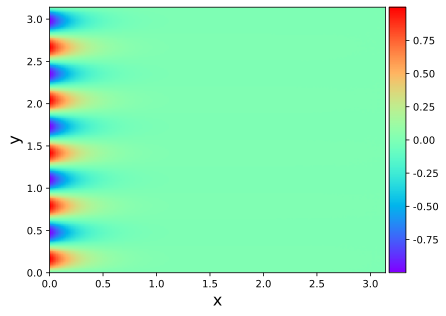

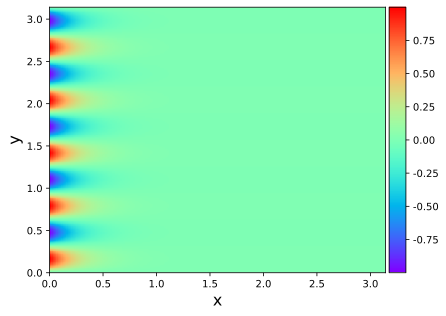

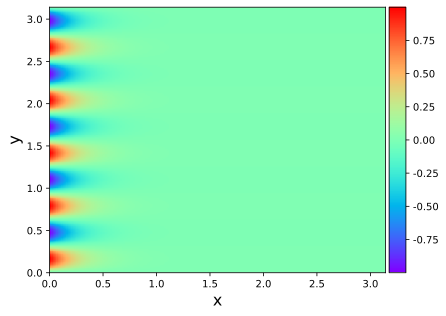

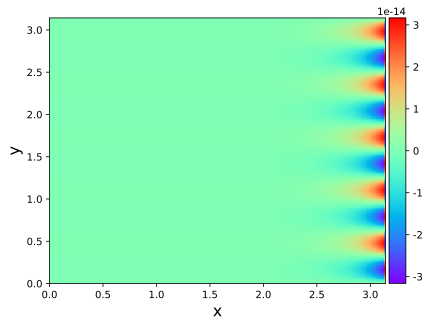

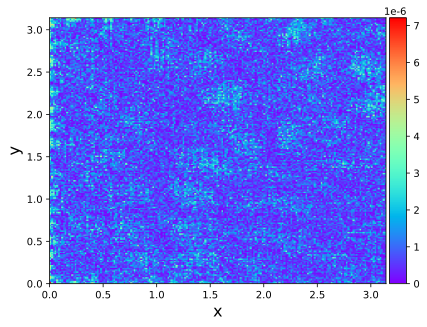

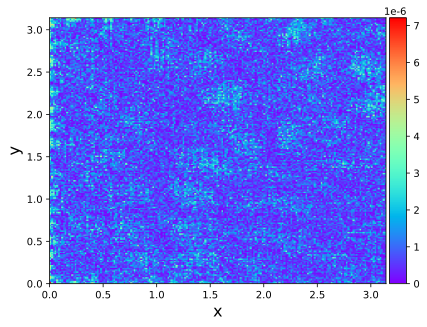

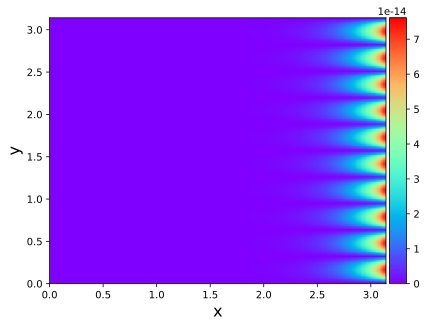

In [48]:
def u_f_exact(x):
    eps = (m/k)**2
    eta = torch.exp(-2*math.sqrt(m**2-k**2)*L2+2*sigma*j_c*math.sqrt(eps-1)*(L2-L1)/(p+1))
    u_l1 = (torch.ge(x[:,0],0)&torch.lt(x[:,0],L1))*(-torch.exp(-math.sqrt(m**2-k**2)*x[:,0])/(eta-1)+\
                                                    eta*torch.exp(math.sqrt(m**2-k**2)*x[:,0]))
    u_l2 = (torch.ge(x[:,0],L1)&torch.lt(x[:,0],L2))*(-torch.exp(-math.sqrt(m**2-k**2)*L1+\
            j_c*math.sqrt(eps-1)*sigma*(L2-L1)*((x[:,0]-L1)**(p+1)/(L2-L1)**(p+1)/(p+1)))/(eta-1)+\
eta/(eta-1)*torch.exp(math.sqrt(m**2-k**2)*L1-j_c*math.sqrt(eps-1)*sigma*(L2-L1)*((x[:,0]-L1)**(p+1)/(L2-L1)**(p+1)/(p+1))))
                                                    
    u = ((u_l1+u_l2)*torch.sin(m*x[:,1])).reshape(-1,1)
    if x.is_cuda:
        u = u.to(device)
    return u

#绘制绝对误差图像
def test_plot(net,n=100,save_path=None):
    x0 = torch.linspace(0, L1, n)
    y0 = torch.linspace(0, pi, n)
    # x0 = torch.linspace(0, 1, n)
    # y0 = torch.linspace(0, 1, n)
    mx, my = torch.meshgrid(x0, y0)
    net = net.cpu()
    with torch.no_grad():
        X = torch.cat((mx.reshape(-1,1),my.reshape(-1,1)),1)
        u = net(X).reshape(-1,n).T
        u_ex = u_exact(X).reshape(-1,n).T
        u_f = u_f_exact(X).reshape(-1,n).T
        u_f_ex = u_f.real
        u_f_ex_imag = u_f.imag
    plot_sol(u,"u",save_path+'/k_%d_u.png'%k)
    plot_sol(u_ex,"u_ex",save_path+'/k_%d_u_ex.png'%k)
    plot_sol(u_f_ex,"u_pml_real",save_path+'/k_%d_u_f_real_ex.png'%k)
    plot_sol(u_f_ex_imag,"u_pml_imag",save_path+'/k_%d_u_f_imag_ex.png'%k)
    plot_sol(abs(u-u_ex),"u-u_ex",save_path+'/k_%d_u_err.png'%k)
    plot_sol(abs(u-u_f_ex),"u-u_pml_real",save_path+'/k_%d_u_f_err.png'%k)
    plot_sol(abs(u_ex-u_f_ex),"u_ex-u_pml_real",save_path+'/k_%d_u_f_ex_err.png'%k)
    
    
def plot_sol(u,title,save_path):
    plt.figure()
    ax =  plt.subplot(1,1,1)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    h = plt.imshow(u, interpolation='nearest', cmap='rainbow',
                   extent=[0, L1, 0, pi],
                   origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h, cax=cax) 
    # plt.title(title)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

test_plot(net,200,'imgs/2d_exam6/')
